# 3D DPP Condition Number Study (Conforming FEM)

This notebook replicates the 2D DPP conditioning analysis for 3D using the manufactured 3D solution. It assembles the monolithic mixed-pressure system with Firedrake on UnitCube meshes, applies Dirichlet BCs from the analytic pressures, and estimates condition numbers for the full matrix and its diagonal blocks.

In [1]:
# Imports and repo path setup for 3D DPP
import sys
from pathlib import Path
import os

os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import firedrake as fd

# perphil imports
from perphil.forms.spaces import create_function_spaces
from perphil.forms.dpp import dpp_form
from perphil.models.dpp.parameters import DPPParameters
from perphil.utils.manufactured_solutions import exact_expressions_3d
from perphil.solvers.conditioning import (
    get_matrix_data_from_form,
    calculate_condition_number,
)

# Ensure project src is importable (if running standalone)
repo_root = Path("..").resolve()
src_path = (repo_root / "src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Output directory
results_dir = (
    repo_root / "notebooks" / "results-conforming-3d" / "conditioning"
).resolve()
results_dir.mkdir(parents=True, exist_ok=True)
print({"results_dir": str(results_dir)})

{'results_dir': '/home/diego/Work/perphil/notebooks/results-conforming-3d/conditioning'}


In [2]:
# Parameters: mesh sizes and estimator settings (3D)
Ns = [4, 6, 8, 10, 12, 14, 16]
pressure_degree = 1
num_of_factors = 0  # use full DoFs (dense SVD) per target matrix
use_sparse = True

# DPP parameters (wrapped to Firedrake Constants internally)
params = DPPParameters(k1=1.0, k2=1e-2, beta=1.0, mu=1.0)

print(
    {
        "Ns": Ns,
        "pressure_degree": pressure_degree,
        "num_of_factors": num_of_factors,
        "use_sparse": use_sparse,
    }
)

{'Ns': [4, 6, 8, 10, 12, 14, 16], 'pressure_degree': 1, 'num_of_factors': 0, 'use_sparse': True}


In [3]:
# Sweep: assemble 3D DPP monolithic matrix and compute condition numbers
rows = []
for N in Ns:
    mesh = fd.UnitCubeMesh(N, N, N)
    # Build scalar pressure space and form mixed space W=V×V
    _, V = create_function_spaces(
        mesh, pressure_deg=pressure_degree, pressure_family="CG"
    )
    W = fd.MixedFunctionSpace((V, V))

    # Manufactured exact pressures for BCs (3D)
    _, p1_exact, _, p2_exact = exact_expressions_3d(mesh, params)
    bcs = [
        fd.DirichletBC(W.sub(0), p1_exact, "on_boundary"),
        fd.DirichletBC(W.sub(1), p2_exact, "on_boundary"),
    ]

    # Assemble bilinear form and extract CSR
    a, _ = dpp_form(W, params)
    md = get_matrix_data_from_form(a, bcs)
    csr = md.sparse_csr_data

    # Diagonal blocks sizes
    n0 = W.sub(0).dim()
    n1 = W.sub(1).dim()

    # Compute condition numbers using robust routine (dense when num_of_factors=0)
    cond_A = calculate_condition_number(
        csr, num_of_factors=num_of_factors, use_sparse=use_sparse
    )
    A00 = csr[:n0, :n0].tocsr()
    A11 = csr[n0 : n0 + n1, n0 : n0 + n1].tocsr()
    cond_A00 = calculate_condition_number(
        A00, num_of_factors=num_of_factors, use_sparse=use_sparse
    )
    cond_A11 = calculate_condition_number(
        A11, num_of_factors=num_of_factors, use_sparse=use_sparse
    )

    # Mesh size h for UnitCube with linear elements (approx 1/N)
    h = 1.0 / float(N)

    row = {
        "N": N,
        "h": h,
        "cond_monolithic": float(cond_A),
        "cond_macro": float(cond_A00),
        "cond_micro": float(cond_A11),
        "n_dofs": int(csr.shape[0]),
        "n0": int(n0),
        "n1": int(n1),
    }
    rows.append(row)
    print(
        f"N={N}: n={csr.shape[0]}, condA={row['cond_monolithic']:.3e}, A00={row['cond_macro']:.3e}, A11={row['cond_micro']:.3e}"
    )

results_df = pd.DataFrame(rows).sort_values("N").reset_index(drop=True)
results_df.head()

N=4: n=250, condA=1.665e+02, A00=5.686e+00, A11=6.391e+01
N=6: n=686, condA=3.562e+02, A00=1.353e+01, A11=1.865e+02
N=8: n=1458, condA=6.222e+02, A00=2.450e+01, A11=4.207e+02
N=8: n=1458, condA=6.222e+02, A00=2.450e+01, A11=4.207e+02
N=10: n=2662, condA=9.644e+02, A00=3.862e+01, A11=8.032e+02
N=10: n=2662, condA=9.644e+02, A00=3.862e+01, A11=8.032e+02
N=12: n=4394, condA=1.407e+03, A00=5.683e+01, A11=1.371e+03
N=12: n=4394, condA=1.407e+03, A00=5.683e+01, A11=1.371e+03
N=14: n=6750, condA=2.218e+03, A00=9.009e+01, A11=2.161e+03
N=14: n=6750, condA=2.218e+03, A00=9.009e+01, A11=2.161e+03
N=16: n=9826, condA=3.295e+03, A00=1.343e+02, A11=3.210e+03
N=16: n=9826, condA=3.295e+03, A00=1.343e+02, A11=3.210e+03


,N,h,cond_monolithic,cond_macro,cond_micro,n_dofs,n0,n1
0,4,0.250000,166.468259,5.686259,63.907442,250,125,125
1,6,0.166667,356.248636,13.527103,186.549127,686,343,343
2,8,0.125000,622.225359,24.504592,420.688812,1458,729,729
3,10,0.100000,964.427181,38.618341,803.154660,2662,1331,1331
4,12,0.083333,1406.546382,56.829795,1370.873080,4394,2197,2197


Saved: /home/diego/Work/perphil/notebooks/results-conforming-3d/conditioning/condition_numbers_3d_vs_h.png


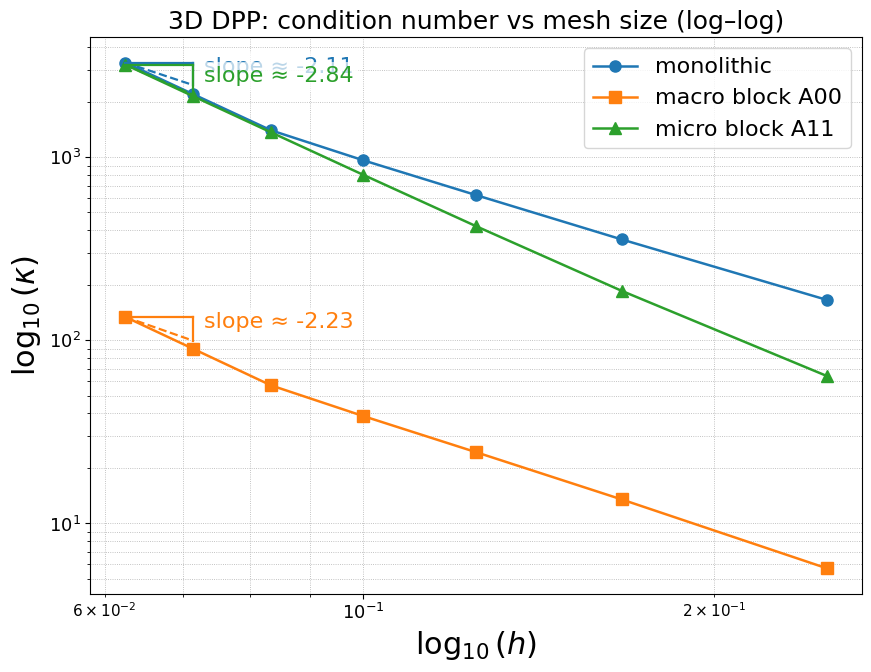

In [4]:
# Plot: κ vs h (log–log), with slope triangles anchored at the two smallest h values
fig, ax = plt.subplots(figsize=(9, 7))
df_plot = results_df.sort_values("h")

line_mono = ax.loglog(
    df_plot["h"],
    df_plot["cond_monolithic"],
    marker="o",
    markersize=8,
    linewidth=1.8,
    label="monolithic",
)[0]
line_macro = ax.loglog(
    df_plot["h"],
    df_plot["cond_macro"],
    marker="s",
    markersize=8,
    linewidth=1.8,
    label="macro block A00",
)[0]
line_micro = ax.loglog(
    df_plot["h"],
    df_plot["cond_micro"],
    marker="^",
    markersize=8,
    linewidth=1.8,
    label="micro block A11",
)[0]

ax.set_xlabel(r"$\log_{10}(h)$")
ax.set_ylabel(r"$\log_{10}(\kappa)$")
ax.grid(True, which="both", ls=":", lw=0.6)
ax.legend(fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=13)
ax.tick_params(axis="both", which="minor", labelsize=11)

# Slopes from log-log fit
m_mono, _ = np.polyfit(
    np.log(df_plot["h"].values), np.log(df_plot["cond_monolithic"].values), 1
)
m_macro, _ = np.polyfit(
    np.log(df_plot["h"].values), np.log(df_plot["cond_macro"].values), 1
)
m_micro, _ = np.polyfit(
    np.log(df_plot["h"].values), np.log(df_plot["cond_micro"].values), 1
)


def annotate_slope_two_smallest(line_x, line_y, slope, color="k"):
    x_vals = np.asarray(line_x, dtype=float)
    y_vals = np.asarray(line_y, dtype=float)
    if x_vals.size < 2:
        return
    i0, i1 = 0, 1
    x0, y0 = float(x_vals[i0]), float(y_vals[i0])
    x1 = float(x_vals[i1])
    f = x1 / x0
    y1_pred = y0 * (f ** float(slope))
    ax.plot([x0, x1], [y0, y0], color=color, lw=1.6)
    ax.plot([x1, x1], [min(y0, y1_pred), max(y0, y1_pred)], color=color, lw=1.6)
    ax.plot([x0, x1], [y0, y1_pred], color=color, lw=1.6, ls="--")
    ax.annotate(
        f"slope ≈ {slope:.2f}",
        xy=(x1, y1_pred),
        xycoords="data",
        xytext=(8, 6),
        textcoords="offset points",
        fontsize=16,
        color=color,
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )


annotate_slope_two_smallest(
    df_plot["h"], df_plot["cond_monolithic"], m_mono, color=line_mono.get_color()
)
annotate_slope_two_smallest(
    df_plot["h"], df_plot["cond_macro"], m_macro, color=line_macro.get_color()
)
annotate_slope_two_smallest(
    df_plot["h"], df_plot["cond_micro"], m_micro, color=line_micro.get_color()
)

ax.set_title("3D DPP: condition number vs mesh size (log–log)", fontsize=18)
plt.tight_layout()
fig_path = results_dir / "condition_numbers_3d_vs_h.png"
plt.savefig(fig_path, dpi=200)
print("Saved:", fig_path)
plt.show()

In [5]:
# Save CSVs
csv_path = results_dir / "conditioning_3d.csv"
results_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

slopes = {
    "monolithic": float(m_mono),
    "macro": float(m_macro),
    "micro": float(m_micro),
}
slopes_path = results_dir / "conditioning_3d_slopes.csv"
pd.DataFrame([slopes]).to_csv(slopes_path, index=False)
print("Saved:", slopes_path)

results_df.head()

Saved: /home/diego/Work/perphil/notebooks/results-conforming-3d/conditioning/conditioning_3d.csv
Saved: /home/diego/Work/perphil/notebooks/results-conforming-3d/conditioning/conditioning_3d_slopes.csv


,N,h,cond_monolithic,cond_macro,cond_micro,n_dofs,n0,n1
0,4,0.250000,166.468259,5.686259,63.907442,250,125,125
1,6,0.166667,356.248636,13.527103,186.549127,686,343,343
2,8,0.125000,622.225359,24.504592,420.688812,1458,729,729
3,10,0.100000,964.427181,38.618341,803.154660,2662,1331,1331
4,12,0.083333,1406.546382,56.829795,1370.873080,4394,2197,2197
